In [1]:
import pandas as pd
import numpy as np
import nltk
# Apply text pre-processing to DataFrame
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer

from textblob import TextBlob, Word
import gensim
from gensim import corpora, models, similarities
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
# Fetch stopwords

# import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS

# stop=set(stopwords.words('english')) #for english
stop=set(stopwords.words('indonesian'))


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20196\1263346607.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# samples= pd.read_csv('dataset/Dataset_clean_textblobvader12112023.csv', encoding='ISO-8859-1')
samples= pd.read_csv('dataset/2.Dataset_NomorUrut_clean_content_textblobvader.csv', encoding='UTF-8')
# samples=samples[['likes','replies','quotes','retweets','searchQuery','clean_content']]

In [3]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306 entries, 0 to 7305
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   text                           7306 non-null   object 
 1   clean_content                  7306 non-null   object 
 2   likes                          7306 non-null   int64  
 3   replies                        7306 non-null   int64  
 4   quotes                         7306 non-null   int64  
 5   retweets                       7306 non-null   int64  
 6   searchQuery                    7306 non-null   object 
 7   user_location                  3472 non-null   object 
 8   tanggal                        7306 non-null   object 
 9   dataset                        7306 non-null   object 
 10  date                           7306 non-null   object 
 11  textblob_sentiment             7306 non-null   object 
 12  textblob_sentiment_assessment  7306 non-null   o

In [4]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['clean_content']:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

In [14]:
#buat corpus untuk LDA
corpus=preprocess_news(samples)

In [15]:
len(corpus)

7306

## WORD2VEC

In [16]:
import re

In [17]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [18]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['clean_content'] = df.clean_content.str.lower()
    df['document_sentences'] = df.clean_content.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists
    return df

wordsamples=w2v_preprocessing(samples)

In [19]:
wordsamples.head()

,text,clean_content,likes,replies,quotes,retweets,searchQuery,user_location,tanggal,dataset,...,textblob_sentiment_assessment,textblob_polarity,textblob_subject,vader_compound,vader_neg,vader_neu,vader_pos,vader_sentiment,document_sentences,tokenized_sentences
0,"Sah, Pasangan Prabowo-Gibran dapat Nomor Urut ...",sah pasang prabowo gibran nomor urut tetap kpu...,0,0,0,0,#nomor,NaN,11/14/2023,prabowogibran,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[sah pasang prabowo gibran nomor urut tetap kp...,"[[sah, pasang, prabowo, gibran, nomor, urut, t..."
1,#nomor 1 Amin menang,nomor amin menang,0,0,0,0,#nomor,NaN,11/15/2023,prabowogibran,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[nomor amin menang],"[[nomor, amin, menang]]"
2,Pak Prabowo mengangkat anak penerbang tucano y...,prabowo angkat anak terbang tucano gugur anak ...,0,0,0,0,#KIM,NaN,11/20/2023,prabowogibran,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[prabowo angkat anak terbang tucano gugur anak...,"[[prabowo, angkat, anak, terbang, tucano, gugu..."
3,"Unboxing Prabowo; Cerita sejarah, deklarasi bu...",unboxing prabowo cerita sejarah deklarasi budi...,1,0,0,0,#KIM,NaN,11/20/2023,prabowogibran,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[unboxing prabowo cerita sejarah deklarasi bud...,"[[unboxing, prabowo, cerita, sejarah, deklaras..."
4,#Nomor 1\n\nIndonesia beradab,nomor indonesia adab,0,0,0,0,#nomor,NaN,11/14/2023,prabowogibran,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[nomor indonesia adab],"[[nomor, indonesia, adab]]"


In [20]:
wordsamples.to_csv( "hasil/3.NomorUrut_cleancontent_textblobvader_word2vec_processing.csv", index=False, encoding='utf-8-sig')

In [21]:
def lda_get_good_tokens(df):
    df['text_clean'] = df.clean_content.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.clean_content))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))
    return df

wordsamplesx=lda_get_good_tokens(samples)

In [22]:
wordsamplesx.head()

,text,clean_content,likes,replies,quotes,retweets,searchQuery,user_location,tanggal,dataset,...,textblob_subject,vader_compound,vader_neg,vader_neu,vader_pos,vader_sentiment,document_sentences,tokenized_sentences,text_clean,tokenized_text
0,"Sah, Pasangan Prabowo-Gibran dapat Nomor Urut ...",sah pasang prabowo gibran nomor urut tetap kpu...,0,0,0,0,#nomor,NaN,11/14/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[sah pasang prabowo gibran nomor urut tetap kp...,"[[sah, pasang, prabowo, gibran, nomor, urut, t...",sah pasang prabowo gibran nomor urut tetap kpu...,"[sah, pasang, prabowo, gibran, nomor, urut, te..."
1,#nomor 1 Amin menang,nomor amin menang,0,0,0,0,#nomor,NaN,11/15/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[nomor amin menang],"[[nomor, amin, menang]]",nomor amin menang,"[nomor, amin, menang]"
2,Pak Prabowo mengangkat anak penerbang tucano y...,prabowo angkat anak terbang tucano gugur anak ...,0,0,0,0,#KIM,NaN,11/20/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[prabowo angkat anak terbang tucano gugur anak...,"[[prabowo, angkat, anak, terbang, tucano, gugu...",prabowo angkat anak terbang tucano gugur anak ...,"[prabowo, angkat, anak, terbang, tucano, gugur..."
3,"Unboxing Prabowo; Cerita sejarah, deklarasi bu...",unboxing prabowo cerita sejarah deklarasi budi...,1,0,0,0,#KIM,NaN,11/20/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[unboxing prabowo cerita sejarah deklarasi bud...,"[[unboxing, prabowo, cerita, sejarah, deklaras...",unboxing prabowo cerita sejarah deklarasi budi...,"[unboxing, prabowo, cerita, sejarah, deklarasi..."
4,#Nomor 1\n\nIndonesia beradab,nomor indonesia adab,0,0,0,0,#nomor,NaN,11/14/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[nomor indonesia adab],"[[nomor, indonesia, adab]]",nomor indonesia adab,"[nomor, indonesia, adab]"


In [23]:
wordsamplesx.to_csv( "hasil/3.NomorUrut_cleancontent_textblobvader_word2vec_2.ldagoodtoken.csv", index=False, encoding='utf-8-sig')

In [24]:
from collections import Counter
tokenized_only_dict = Counter(np.concatenate(samples.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [25]:
tokenized_only_df.head(10)

,count
sah,22
pasang,654
prabowo,1960
gibran,983
nomor,3258
urut,2638
tetap,150
kpu,294
newstalk,3
id,164


In [26]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

In [27]:
print(tokenized_only_df)

         count
nomor     3258
paslon    2645
urut      2638
ganjar    2340
prabowo   1960
...        ...
almond       1
light        1
enek         1
awet         1
tafsir       1

[7654 rows x 1 columns]


In [28]:
tokenized_only_df.to_csv( "hasil/3.NomorUrurt_cleancontent_textblobvader_word2vec_3.tokenizedcount.csv", index=False, encoding='utf-8-sig')

## TFIDF TOPIC

In [29]:
#buat dictionary corpus
dic=gensim.corpora.Dictionary(corpus)


In [30]:
#buat dictionary corpus
print(dic)

Dictionary<7142 unique tokens: ['gibran', 'kpu', 'nasional', 'newstalk', 'nomor']...>


In [31]:
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [32]:
print(bow_corpus)

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2)], [(4, 1), (11, 1), (12, 1)], [(4, 1), (7, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(7, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (24, 1), (25, 1), (26, 1), (27, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(4, 1), (39, 1), (40, 1)], [(0, 1), (1, 1), (4, 4), (7, 1), (10, 4), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)], [(0, 1), (7, 1), (12, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (24, 1), (25, 1), (26, 1), (34, 1), (38, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1)], [(0, 1), (7, 1), (12, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (24, 1), (25, 1), (26, 1), (34, 1), (38, 1), (59, 1), (60, 1), (61, 1),

In [33]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

In [34]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)

In [35]:
lda_model = LdaModel(corpus=bow_corpus,
                   id2word=dic,
                   num_topics=4,
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   passes=10,
                #    workers=2,
                   per_word_topics=True)

In [36]:
lda_model.show_topics()

[(0,
  '0.058*"nomor" + 0.055*"urut" + 0.050*"ganjar" + 0.040*"prabowo" + 0.031*"ganjarpranowo" + 0.028*"ganjarmahfud" + 0.027*"subianto" + 0.027*"presiden" + 0.026*"mahfud" + 0.022*"mahfudmd"'),
 (1,
  '0.028*"nomor" + 0.026*"com" + 0.024*"pilpres" + 0.023*"anies" + 0.021*"urut" + 0.021*"milu" + 0.020*"capres" + 0.018*"cawapres" + 0.012*"muhaimin" + 0.011*"hasil"'),
 (2,
  '0.064*"paslon" + 0.023*"rakyat" + 0.022*"desa" + 0.022*"dukung" + 0.021*"fyp" + 0.019*"biar" + 0.014*"salah" + 0.013*"viral" + 0.013*"politik" + 0.013*"rusak"'),
 (3,
  '0.077*"paslon" + 0.024*"dukung" + 0.019*"menang" + 0.018*"nya" + 0.017*"amin" + 0.010*"islam" + 0.009*"pilih" + 0.009*"salah" + 0.008*"rakyat" + 0.008*"misi"')]

In [25]:
# g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
# plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

## Visualize the Topic

Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.

Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed. 

Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image below, there are about 22,000 of the word ‘go’, and this term is used about 10,000 times within topic 1. The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.


In [37]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.280425 -0.137379       1        1  41.177021
3     -0.203531 -0.198122       2        1  22.113858
1      0.129299  0.200836       3        1  19.940992
2     -0.206193  0.134666       4        1  16.768129, topic_info=              Term         Freq        Total Category  logprob  loglift
250         paslon  3015.000000  3015.000000  Default  30.0000  30.0000
46          ganjar  2219.000000  2219.000000  Default  29.0000  29.0000
7          prabowo  1798.000000  1798.000000  Default  28.0000  28.0000
10            urut  2898.000000  2898.000000  Default  27.0000  27.0000
120  ganjarpranowo  1386.000000  1386.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
183           milu   134.724632   596.541152   Topic4  -4.9025   0.2978
45        cawapres   141.148526   999.695735   Topic4  -4.8559  -0.1719
103          pilih   129.034867   786.983664   Topic4  -4.9456  -0.0224
4            nomor   135.521859  3469.669598   Topic4  -4.8966  -1.4570
44          capres   111.623780  1480.156278   Topic4  -5.0906  -0.7991

[207 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
112       1  0.996272  acara
67        4  0.983614    air
11        2  0.997793   amin
13        4  0.996555   anak
41        3  0.999218  anies
...     ...       ...    ...
764       4  0.997784  viral
621       1  0.526543   visi
621       2  0.471695   visi
402       1  0.997262  wakil
111       2  0.997714    yuk

[202 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

The further the bubbles are away from each other, the more different they are. For example, it is difficult to tell the difference between topics 1 and 2. They seem to be both about social life, but it is much easier to tell the difference between topics 1 and 3. We can tell that topic 3 is about politics.

## LDA MALLET

## WORDCLOUD GENERATION

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1 
        )
    
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

c:\laragon\bin\python\python-3.10\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


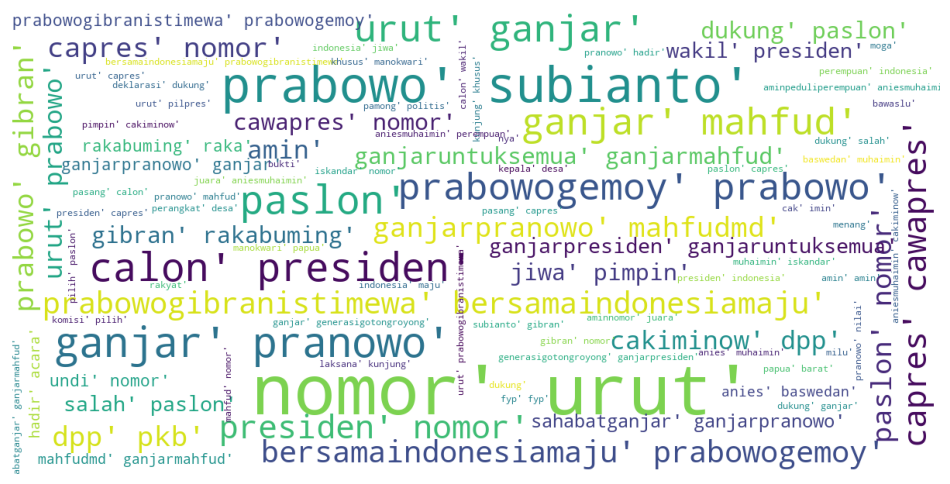

In [40]:
show_wordcloud(corpus)

In [30]:
!pip install nbformat

In [41]:
# import plotly.plotly as py
from chart_studio.grid_objs import Grid, Column
from chart_studio import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.figure_factory as FF

In [42]:
tokenized_only_df.head(25)

,count
nomor,3258
paslon,2645
urut,2638
ganjar,2340
prabowo,1960
presiden,1344
amin,1286
capres,1239
yang,1184
mahfud,1119


In [43]:
len(tokenized_only_df)

7654

In [44]:
tokenized_only_df.shape

(7654, 1)

In [46]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=20):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    sns.barplot(x=df.values, y=df.index, alpha=0.8)

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    


In [39]:
# ax = word_frequency_barplot(tokenized_only_df)
# ax.set_title("Word Frequencies", fontsize=16);

In [47]:
samples['date'] = pd.to_datetime(samples['date'], format='mixed')
samplesT = samples['date']

trace = go.Histogram(
    x=samplesT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Months',
    height=450,
    width=1200,
    xaxis=dict(
        title='Date and Month'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
pyoff.iplot(fig)

In [48]:
datestat=samples.groupby(['date'],as_index=False).size()
# searchstat.to_frame()

In [49]:
datestat.head(10)

,date,size
0,2023-11-14,312
1,2023-11-15,370
2,2023-11-16,228
3,2023-11-17,625
4,2023-11-18,358
5,2023-11-19,889
6,2023-11-20,4524


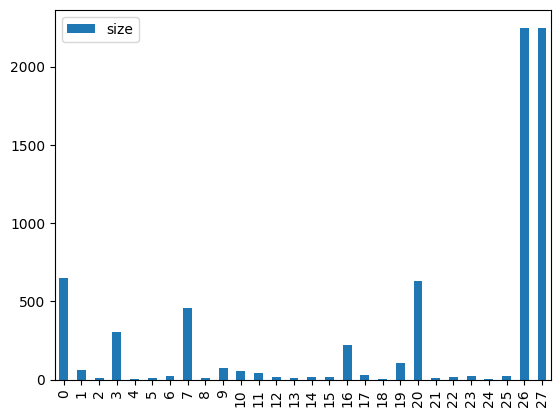

In [52]:
searchstat=samples.groupby(['searchQuery'],as_index=False).size().plot(kind='bar')


In [51]:
searchstat.head(10)

AttributeError: 'Axes' object has no attribute 'head'

<Axes: xlabel='count', ylabel='date'>

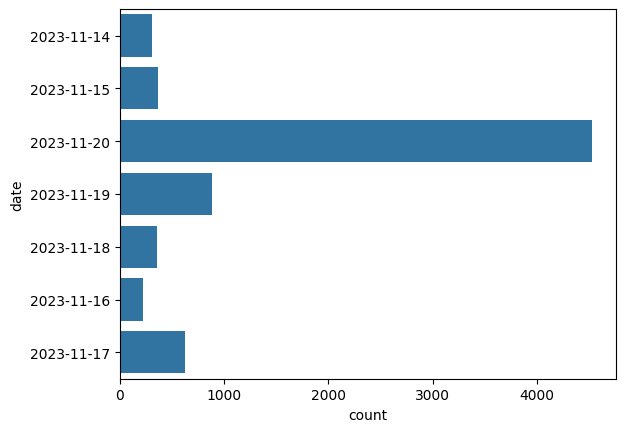

In [64]:
sns.countplot(samples['date'])

<Axes: xlabel='count', ylabel='dataset'>

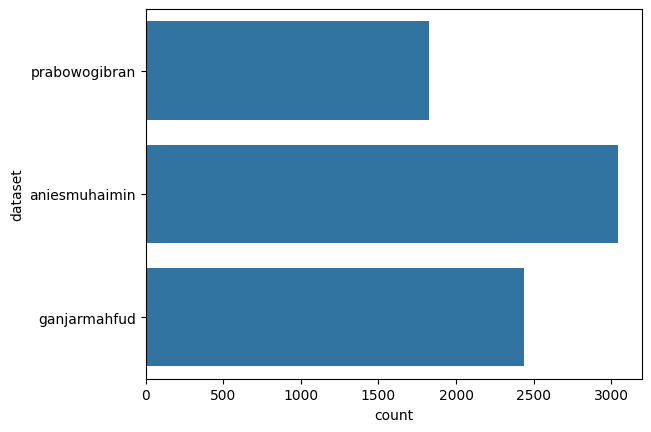

In [63]:
sns.countplot(samples['dataset'])

<Axes: xlabel='count', ylabel='searchQuery'>

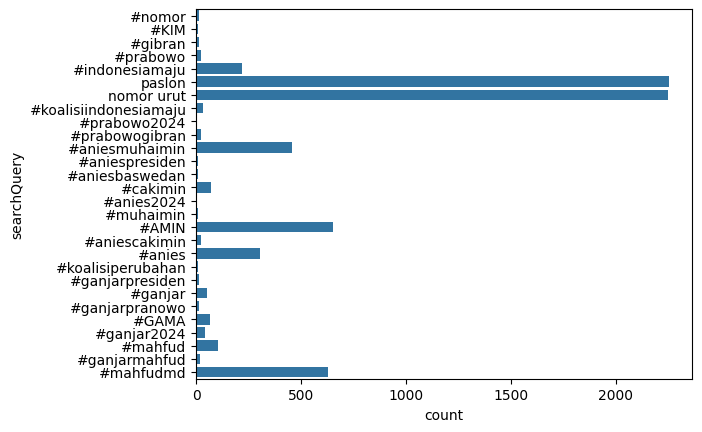

In [53]:
sns.countplot(samples['searchQuery'])

## Vectorize Word

In [54]:
samples.head()

,text,clean_content,likes,replies,quotes,retweets,searchQuery,user_location,tanggal,dataset,...,textblob_subject,vader_compound,vader_neg,vader_neu,vader_pos,vader_sentiment,document_sentences,tokenized_sentences,text_clean,tokenized_text
0,"Sah, Pasangan Prabowo-Gibran dapat Nomor Urut ...",sah pasang prabowo gibran nomor urut tetap kpu...,0,0,0,0,#nomor,NaN,11/14/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[sah pasang prabowo gibran nomor urut tetap kp...,"[[sah, pasang, prabowo, gibran, nomor, urut, t...",sah pasang prabowo gibran nomor urut tetap kpu...,"[sah, pasang, prabowo, gibran, nomor, urut, te..."
1,#nomor 1 Amin menang,nomor amin menang,0,0,0,0,#nomor,NaN,11/15/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[nomor amin menang],"[[nomor, amin, menang]]",nomor amin menang,"[nomor, amin, menang]"
2,Pak Prabowo mengangkat anak penerbang tucano y...,prabowo angkat anak terbang tucano gugur anak ...,0,0,0,0,#KIM,NaN,11/20/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[prabowo angkat anak terbang tucano gugur anak...,"[[prabowo, angkat, anak, terbang, tucano, gugu...",prabowo angkat anak terbang tucano gugur anak ...,"[prabowo, angkat, anak, terbang, tucano, gugur..."
3,"Unboxing Prabowo; Cerita sejarah, deklarasi bu...",unboxing prabowo cerita sejarah deklarasi budi...,1,0,0,0,#KIM,NaN,11/20/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[unboxing prabowo cerita sejarah deklarasi bud...,"[[unboxing, prabowo, cerita, sejarah, deklaras...",unboxing prabowo cerita sejarah deklarasi budi...,"[unboxing, prabowo, cerita, sejarah, deklarasi..."
4,#Nomor 1\n\nIndonesia beradab,nomor indonesia adab,0,0,0,0,#nomor,NaN,11/14/2023,prabowogibran,...,0.0,0.0,0.0,1.0,0.0,Neutral,[nomor indonesia adab],"[[nomor, indonesia, adab]]",nomor indonesia adab,"[nomor, indonesia, adab]"


In [55]:
from gensim.corpora import Dictionary

In [56]:

dictionary = Dictionary(documents=samples.tokenized_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 7654 words.


In [57]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.tokenized_text))
    
document_to_bow(samples)

In [58]:
print(document_to_bow)

<function document_to_bow at 0x000001ACC7D45FC0>


In [ ]:


# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)



In [59]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [60]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

In [61]:
cleansed_words_df.head()

,count
nomor,2871
urut,2427
paslon,2350
ganjar,1629
prabowo,1331


In [ ]:


# ax = word_frequency_barplot(cleansed_words_df)
# ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);



In [62]:
# df = pd.DataFrame({'date': s.index, 'Category': s.values})
# samples['Week/Year'] = samples['date'].apply(lambda x: "%d/%d" % (x.week, x.year))
# samples.groupby(['Week/Year', 'Category']).size()
samples.groupby(['date']).size()

date
2023-11-14     312
2023-11-15     370
2023-11-16     228
2023-11-17     625
2023-11-18     358
2023-11-19     889
2023-11-20    4524
dtype: int64